# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

## Question 1: Reading

1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).

2. How is this task different from a SLAM problem?

### Answer 1: Building Rome in a Day

> **Paper**: S Agarwal (2009) - Building Rome in a day; available at [10.1109/ICCV.2009.5459148](https://doi.org/10.1109/ICCV.2009.5459148)


**Introduction**

The paper aims to address the problem of large scale depth reconstruction from images of a city. Precisely, instead of using custom setups to capture images (like how Google Maps data is collected), it uses images from publicly accessible image databases (like [flickr](https://www.flickr.com/)). A key problem addressed by this paper is scaling the image correspondence, bundle adjustment optimization, and the map creation process; thereby effectively distributing it across multiple compute cores (a compute cluster).

This is particularly challenging when it comes to data distribution and lifecycle management of detected features. The code system design is divided into various parts (that are implemented on different nodes on the cluster, using an efficient job distribution and scheduling manager). Two of the most important parts are described below (in the following two cells)

**Image Matching** and **Correspondence Validation**

The image features are detected using SIFT features. These matches are pruned and verified using a RANSAC algorithm that uses the fundamental or the essential matrix (in some cases, the [EXIF](https://en.wikipedia.org/wiki/Exif) / metadata of the images contains the focal length of the camera using which the image was taken; if no focal length information is available, fundamental matrix is used instead).

Pair-wise matching cannot be scaled to large databases (imagine $^n\textup{C}_2$ value for $n=100,000$), and pair-wise comparisons don't even make sense (many pairs will not match as they won't be capturing the same scene). A multi-stage image matching scheme is therefore proposed. Each stage has a proposal and verification. Proposals (of potential image pairs) are generated using vocabulary tree and based on query expansion.

In a vocabulary tree, feature descriptors of images are stored in a k-Means tree. Basically, images are quantized into vector spaces that can be addressed quickly and, likely images of the same scenes (having similar descriptors) are stored closer together. This is like finding a huge embedding space for images.

In query expansion, a query is expanded (dynamically) when new data pertaining to this query is found. This yields a hugely connected graphs linking potential pairs together. The graph needs to be maintained, so geometric verification of image pairs are used before adding them to the graph.

After this, the correspondence has to be _validated_ (so that it is ensured that it is indeed correct). This is a two step process. The first step is photometric matching between feature descriptors and the second is the estimation of fundamental or essential matrix (depending on the availability of focal length data). In case an essential matrix is recovered and there is good angle between the viewing directions (this can be found by decomposition of the essential matrix), a full two-view Euclidean reconstruction is done and stored. This helps to reduce the size of the reconstruction problem (and to also estimate the initial parameters of the optimization).

Ultimately, a _track_ is generated that helps us to find and label all of the connected components in the graph of individual feature matches.

**Geometric Estimation**

The SfM problem is solved using **Bindle Adjustment**: a large scale optimization procedure where the projection error for every scene is aimed to be minimized, and the camera projection matrices and the world point coordinates are aimed to be found. For such a large scale optimization, the sparse nature of the problem is exploited (not every image is related to the other, not every camera parameter is related to the other). This gives huge computational savings, and also allows the problem to be solved in a parallel fashion (unrelated parts can be solved on separate cores and then gradients can be concatenated and applied). The authors developed methods over Sparse Bundle Adjustment algorithm (the then state-of-the-art algorithm) to handle the problem complexity.

### Answer 2: Difference from SLAM

In the first overview, SLAM (Simultaneous Localization and Mapping) and Bundle Adjustment (an SfM - Structure from Motion - problem) appear similar. However, key differences are described below


In a typical SLAM problem, the poses (localization) and the environment (mapping) are found through filtering or smoothing. This is not very different from the expected results of a bundle adjustment problem (camera poses / parameters and the scene reconstruction as a 3D point cloud). However, the mapping in SLAM involves a more complex process. SFM / Bundle Adjustment do not usually incorporate building maps through landmark locations (they work on entire scene reconstruction). SLAM is more complete, as it also incorporates the entire mapping process as well. SLAM also incorporates constraints like loop closure. However, for this (the SLAM solution) to work, the front end needs to incorporate landmark identification and lifecycle management algorithms.

SLAM could use Bundle Adjustment as a mean to refine updates (smoothing), but filtering techniques like Kalman Filtering are more widely used (alone or in conjunction with bundle adjustment).

Finally, SLAM implementations (usually) can leverage data from other types of sensors (like GPS, IMU, etc.) better than Bundle Adjustment can: which, in its raw form, will use that data only as initial estimates.


## Question 2: Code!

### Task

We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from [Bundle Adjustment in Large](https://grail.cs.washington.edu/projects/bal/) for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [1]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


First download the data file:

In [2]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "final/"
# FILE_NAME = "problem-13682-4456117-pre.txt.bz2" # Too Huge!
# FILE_NAME = "problem-93-61203-pre.txt.bz2"  # Testing a small file
FILE_NAME = "problem-394-100368-pre.txt.bz2"  # Testing a small file

URL = BASE_URL + DATASET_NAME + FILE_NAME

In [3]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [4]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [5]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [6]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (394, 9);
points_3d: (100368, 3);
camera_indices: (534408,); 
point_indices: (534408,); 
points_2d: (534408, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

### Visualize Point Cloud

Visualize `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [7]:
# Geometries
cf = o3d.geometry.TriangleMesh.create_coordinate_frame(0.5)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
o3d.visualization.draw_geometries([pcd, cf])

### Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [8]:
n_cameras = camera_params.shape[0]  # Number of cameras
n_points = points_3d.shape[0]   # Number of 3D points
m = 2*points_2d.shape[0]    # 2 (x, y) eqs per point / observation
n = 9*n_cameras+3*n_points  # Number of parameters to estimate

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 394
n_points: 100368
Total number of parameters to estimate: 304650
Total number of residuals: 1068816


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

In [9]:
# Check function `fun` !

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [10]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

### A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up

Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.

![radial_distortion_1.png](./../misc/radial_distortion_1.png) 
![radial_distortion_2.png](./../misc/radial_distortion_2.png)

In [11]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    
    #############################
    #
    # TO DO : Implement this function based on the information mentioned above.
    #
    #############################
    # print("=== Project function entrance ===")
    # print(f"Points: {points.shape}")    # n_obs, 3
    # print(f"Camera Parameters: {camera_params.shape}")  # n_obs, 9
    # Transform point in camera frame
    pts_cam = rotate(points, camera_params[:,:3])   # Rotate
    pts_cam = pts_cam + camera_params[:, 3:6]   # Points in {camera}
    # print(f"Points in (cam): {pts_cam.shape}")
    # Points in homogeneous pixel coordinates (no dist. and focus)
    qx = pts_cam[:, [0]]/pts_cam[:, [2]]
    qy = pts_cam[:, [1]]/pts_cam[:, [2]]
    q = -np.hstack((qx, qy)) # No focus and distortion yet
    # print(f"q (homogeneous unscaled): {q.shape}")
    # Apply distortion
    norm_q = np.linalg.norm(q, axis=1).reshape(-1, 1)   # row-wise
    # print(f"q norm: {norm_q.shape}")
    k1 = camera_params[:, [7]]  # norm^2 - k1 parameter
    k2 = camera_params[:, [8]]  # norm^4 - k2 parameter
    # print(f"K1: {k1.shape}, K2: {k2.shape}")
    d_vect = 1 + k1 * (norm_q**2) + k2 * (norm_q**4)    # Dist. vect.
    # print(f"Dist. vect: {d_vect.shape}")
    distq = d_vect * q  # Distortion applied
    # print(f"Distorted q: {distq.shape}")
    # Apply focus
    f = camera_params[:,[6]]    # Focal length values
    # print(f"F: {f.shape}")
    points_proj = f * distq     # Projected points
    # print(f"Projected points: {points_proj.shape}")
    # print("=== Project function exit ===")
    # raise NotImplementedError("TODO - Hold on")
    return points_proj

In [12]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

### A short review on Structure from Motion


#### Residual

In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)

![sfm_residual_1.png](./../misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](./../misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of data structures that are meant for such a use case - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [13]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [14]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):

    # print(f"Num. Cameras: {n_cameras}")
    # print(f"Num. Points: {n_points}")
    # print(f"Cam. Indices: {camera_indices.shape}")
    # print(f"Point Indices: {point_indices.shape}")
    # raise NotImplementedError("TODO: Work in progress")
    m = 2 * point_indices.shape[0]  # 2*num_obs: Num. rows in residual
    n = 9*n_cameras + 3*n_points    # Number of paramters
            
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A

### THAT'S IT! Now we are ready to use inbuilt library functions!

Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [15]:
import matplotlib.pyplot as plt

In [16]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [17]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

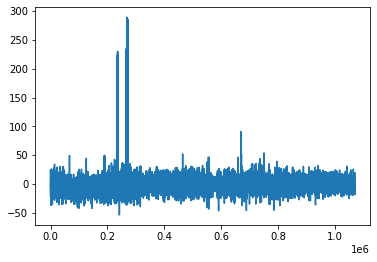

In [18]:
plt.plot(f0)

In [19]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

(1068816, 304650) 394 100368


### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

In [20]:
import time
from scipy.optimize import least_squares

In [21]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5457e+06                                    4.04e+07    
       1              7         4.5418e+06      3.91e+03       6.94e-02       4.05e+07    
       2              8         4.5316e+06      1.02e+04       6.93e-02       4.06e+07    
       3              9         4.5276e+06      4.06e+03       1.39e-01       4.08e+07    
       4             10         4.5166e+06      1.09e+04       3.46e-02       4.09e+07    
       5             11         4.5020e+06      1.46e+04       6.92e-02       4.10e+07    
       6             13         4.4985e+06      3.52e+03       3.55e-02       4.10e+07    
       7             14         4.4940e+06      4.52e+03       3.38e-02       4.11e+07    
       8             15         4.4905e+06      3.46e+03       3.55e-02       4.11e+07    
       9             16         4.4861e+06      4.46e+03       3.38e-02       4.12e+07    

In [22]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [23]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
cf = o3d.geometry.TriangleMesh.create_coordinate_frame(2)
o3d.visualization.draw_geometries([pcd, cf])

In [24]:
# Older point cloud, just for reference
# Geometries
cf = o3d.geometry.TriangleMesh.create_coordinate_frame(2)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
o3d.visualization.draw_geometries([pcd, cf])

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [25]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 274 seconds


Now let's plot residuals at the found solution:

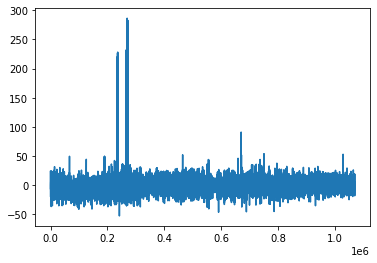

In [26]:
plt.plot(res.fun)

**This might not have worked as expected**

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).


# Project 2- Part B: Submission details

You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

## Theory


### 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.


**Questions**

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics:
    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: 
    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: 

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: 
        
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian:
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: 
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters:        
            
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 6 - Sparsity, Residual Vector & Jacobian: 

### Answers: SfM Pipeline

#### Answer 1

In a practical setting, we will be given the cameras with images, or some identifier associated with images (which could help us find which camera they were taken with). If we're directly given cameras (with say images in the memory) or likewise, the our job is simply a dictionary storage and search (we know the camera each image belongs to).

If we're not given that data, just a set of images from a source like flickr, then we might want to inspect image properties like the user who uploaded it (they likely used the same camera), metadata information, etc. to find the camera a particular image was taken with.

Note that we could also associate images with common camera models (in the worst case).

#### Answer 2

This could be obtained if we have a depth sensor in our setup (which could give us something like a point cloud). Then, if our cameras are calibrated, we can find the projected ray (of a pixel) in 3D space, and run a linear search along that ray to see which point in the point cloud it approximately hits. This will give us the correspondence for 2D (point in image) to 3D (point in real world).

If we do not have a depth sensor, then we may need at least two images of the scene for which we know the focal lengths, and these have a good baseline and rotation. We can then find the corresponding 3D point through triangulation: project the rays of the pixels in the images and see where they meet in 3D space. Note that since we _already_ have a set of 3D points (through our initial estimates), we'll have to associate on something like a nearest neighbor basis.


#### Answer 3

The [Rodrigues' rotation formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) is basically a conversion through a [matrix exponential](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation#Exponential_map_from_%F0%9D%94%B0%F0%9D%94%AC(3)_to_SO(3)) (we get the result directly through taylor expansion). It converts a vector of three numbers (denoted by $\theta\mathbf{\hat{n}}$) into a rotation matrix. We use this property here to transform / rotate the points.

A standard rotation matrix, represented by group $\textup{SO}(3)$ is a 3-by-3 orthogonal matrix. It has 9 elements with 6 constraints (rotations in 3D space have 3 degrees of freedom). This creates a complex manifold, on which we cannot run optimization processes easily. Rotation matrices cannot be simply added, they have to be multiplied (they follow a separate lie algebra).

On the other hand, the exponential representation allows us to have fewer numbers (just 3, which is the minimal). It can also be added to a better degree (unless the addition leads to a singularity). It's manifold is more easier to optimize on, therefore it is used instead.

Another option is to use quaternions, which are 4 number representations and have no singularity issues.

#### Answer 4

Yes. It would make a difference. The correct point is obtained by doing the rotation first, and then translation. Basically, the order of rotation and translation matter. This is because if we translate first, we've basically shifted our origin (we've reached some other place in the world, defined by our _original_ axis, not _rotated_ axis). Now, no rotation can get us to the desired origin (origin defined in the _rotated_ axis, which is the translation vector).

Basically, the homogeneous transform is $\mathbf{p}_{final} = \mathbf{R} \times \mathbf{p} + \mathbf{t}$ and not $\mathbf{p}_{final} = \mathbf{R} \times (\mathbf{p} + \mathbf{t})$. Both these results are two completely different points.

#### Answer 5

In the lecture notes, the number of points is $n$ and the number of cameras is $m$. It is assumed that _every_ point is captured by _every_ camera, yielding us $mn$ pixels (observations). Since each pixel has 2 values (the $x$ and $y$), we got $2mn$ rows for the jacobian (residual will also have the same number of rows).

However, in practice, such an assumption does not hold very well. We might not observe all of the $n$ points in each of the $m$ images. We will only observe a few points of interest in each image (every image will not have some points of interest and may contain some new points of interest). Due to this, the number of rows of the jacobian (or the length of the residual) is actually $2n_{obs}$ (where $n_{obs}$ is the number of observations). The value of $2mn$ is sort of an upper bound.


#### Answer 6

**6.1**: **Individual Motion Jacobian** size is `n_cameras * 9`

It all depends on the way we parameterize the camera projection matrix. In the notes, each camera is assumed to have 5 parameters for the intrinsics (two focal lengths, two center offsets, and one pixel shear), 6 parameters for extrinsics (3 for rotation and 3 for translation). Here, these are reduced to only the focal length and two distortion parameters for intrinsics, while the 6 parameters for the extrinsics remain (3 each for rotation and translation).

Hence, the camera here is parameterized by only 9 numbers, instead of 12. This reduces the size of every individual motion jacobian.

**6.2**: **Number of parameters** for the jacobian

The number of parameters in the notes is $12m+3n$ where $m$ is number of cameras (value of `n_cameras` here) and $n$ is the number of 3D points being estimated (value of `n_points` here). This was because there were 12 parameters for every camera and 3 parameters for every point (that was to be found). Here, the number of parameters for every camera is just 9. Hence, the number of parameters here is $9m+3n$.

The number of variables / parameters by each camera has reduced from 12 to 9. The number of parameters by each 3D point still remains 3.


#### Answer 7

For this example code, the given sample scenario is considered. There are 3 points in the environment (each having its own X, Y, Z). Each of these three points is captured by each of the three cameras in the environment.

The images taken by these cameras will have many pixels (ideally), but for this problem, let's say that we already have an algorithm that detects these points in images (maybe these points could have different colors), and returns those pixel coordinates. So from each image / camera, we get three pixel coordinates (x, y values of pixel in image, could be from the center of image, not the top left corner frame; as is here). So, we have 9 pixels in total (3 pixels from each of 3 cameras). These nine pixels have a pixel to world point correspondence (`point_indices` in the code above) and they also have pixel to camera correspondence (`camera_indices` in the code above). Note that the correspondence here, just says _which_ point or camera (depending on the array) does the particular pixel represent or belong to.

For the code below, the following variable definitions can be noted
- `m_cams`: Number of cameras in the scene. 3 in our case.
- `n_pts`: Number of 3D points in the scene. 3 in our case.
- `pt_is`: The correspondence of the 9 pixels (from the camera images) to the points in the world. Let's assume that our detection and stacking algorithm gave this (in a practical setting).
- `cam_is`: The correspondence of the 9 pixels to the cameras in the world. Since we know which camera took which image, this can be readily obtained.
- `c`: This is the _sparse jacobian matrix_ returned by `bundle_adjustment_sparsity`. The code above described this as `A`.

In [27]:
m_cams = 3
n_pts = 3
# Points seen (concatenated in image vector, like points_2d)
pt_is = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])   # World points (corr)
# Points taken from camera (correspondence for vector like points_2d)
cam_is = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])  # Camera (corr)
c = bundle_adjustment_sparsity(m_cams, n_pts, cam_is, pt_is)

Let us visualize the Jacobian as an image. Note that only the grid intersection values matter here (kind of how the image can be visualized as a matrix).

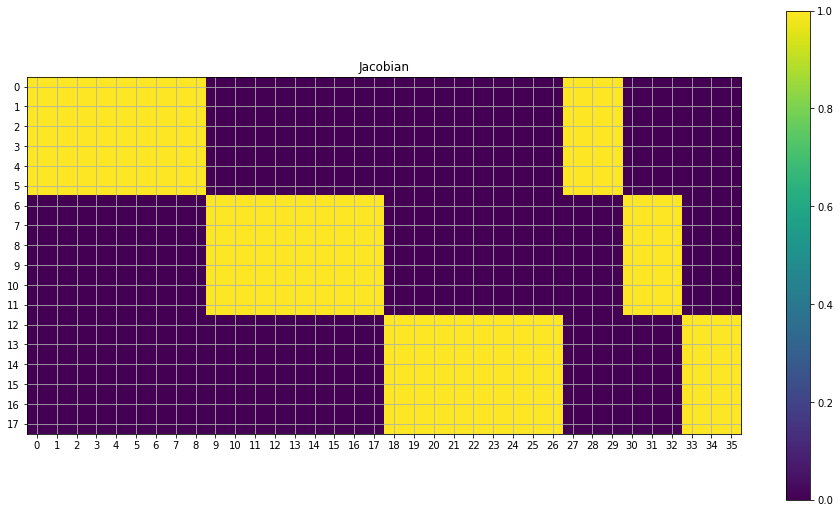

Jacobian shape is: (18, 36)


In [28]:
plt.figure(figsize=(16, 9))
plt.title("Jacobian")
plt.imshow(c.toarray())
plt.grid(True)
plt.yticks(np.arange(2*m_cams*n_pts))
plt.xticks(np.arange(9*m_cams+3*n_pts))
plt.colorbar()
plt.show()
print(f"Jacobian shape is: {c.shape}")

To compute the residuals (using the function `fun` above), we'll first need our parameter estimates, as well as pixel locations of the points in the image. Let's start with parameter estimates first. We have 9 parameters per camera (3 cameras) and 3 parameters per 3D point (3 points). This parameter vector is stored in `ev`. This is same as `x0` in the code above (initial estimates). However, we'll just use random data here (in a realistic setting, this should be initial estimates).

In [29]:
# 9 camera parameters of m_cams: camera_params (initial estimate)
cx_params = np.random.rand(9 * m_cams)
# 3 initial estimates of n_pts: points_3d
px_params = np.random.rand(3 * n_pts)
# Parameter vector
ev = np.hstack((cx_params, px_params))

The image too has to be created. We'll simply assume that we have the image pixels and we'll store them in `pix_2d_vect` here. This is similar to the `points_2d` (pixels in 2D) described in code above. Note that we have 3 cameras and each camera gives three pixels (each pixel has 2 values: x, y arranged as columns). Therefore, the first three rows is from camera 1, then from camera 2, then from camera 3. Check the `cam_is` above (camera correspondence).

In [30]:
# Pixels of the images
pix_2d_vect = np.random.rand(3 * m_cams, 2)

Now, we can compute the residuals (the error in the projection and actual pixels) using the `fun` function. The residuals here is described as `rvect`. In the code above, we passed this (callable function for residuals) to the function [least_squares](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) for optimization.

In [31]:
# Compute the residuals
rvect = fun(ev, m_cams, n_pts, cam_is, pt_is, pix_2d_vect)
print(f"Residual shape: {rvect.shape}")

Residual shape: (18,)


In [32]:
# Single stage of Gradient Descent like step
Jc = c.toarray()
d_ev = Jc.T @ rvect  # Change in paraemters
ev_new = ev - (0.01) * d_ev
print(f"Old parameter vector shape: {ev.shape}")
print(f"New parameter vector shape: {ev_new.shape}")

Old parameter vector shape: (36,)
New parameter vector shape: (36,)


This completes a brief step of the optimization process. The non-linear least squares solver used in the code above is _much_ more efficient.

### 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

### Answer: Initial estimates for SfM

The SfM algorithm (or Bundle Adjustment) requires 'good enough' estimates to converse fast and to a good optima. The process is described in the next two cells.

#### R and t estimates for camera

To estimate R, t and the 3D points (as initial estimates), we'll need some way to triangulate them (if we're only given images and the camera intrinsics). Here's briefly how we can go about getting the initial estimates

1. It is assumed that there is an algorithm that has given us the pixel correspondences ([SIFT](https://docs.opencv.org/4.x/d7/d60/classcv_1_1SIFT.html) or some [keypoint detection and matching](https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html) can be used along with some neighborhood estimates or embedding formation).
2. Knowing the corresponding pixels, and given the camera intrinsic parameters we can use 5 point algorithm solvers to estimate the essential matrix. This can be done through the function [findEssentialMat](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad245d60e64d0c1270dbfd0520847bb87). This essential matrix includes the baseline information (vector as skew symmetric cross product matrix) and the rotation matrix.
3. Decompose the essential matrix to obtain the possible translation vector (baseline) and rotation matrices. This uses an SVD technique and is implemented in [decomposeEssentialMat](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga54a2f5b3f8aeaf6c76d4a31dece85d5d). These two steps (2 and 3) can also be done directly, through one function call, using [recoverPose](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1b2f149ee4b033c4dfe539f87338e243). 

This solves our problem of finding the initial estimates of camera poses. That is, we have the initial estimates of the camera parameters given by R, t and we already have the K matrix.


#### Estimates for the 3D points

To find the initial estimates of the 3D points, either of the two methods can be used

1. **Triangulate points** directly: This can be done if we have the camera projection matrices (we already have calibrated cameras / we know the intrinsics). A set of feature points / corresponding pixels can be triangulated (project rays outwards and see where they meet) using the function [triangulatePoints](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad3fc9a0c82b08df034234979960b778c). It takes in the projection matrices of the cameras (given by $P$) and the corresponding points, and returns the 3D points (in homogeneous coordinates). This can then be used to get the euclidean 3D points. This is just a function call, but requires very good correspondence estimates.

2. Find points through **stereo to depth**: Here, we first create the two images into a stereo pair (hopefully there is a good enough baseline). We already know the rotation and translation between the cameras (through the previous steps). 
    1. We can now undistort the images. This can be done by first using [stereoRectify](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6) to get the homographies. The results of this can actually also be used to verify the estimates of R and t for the camera. This function returns the rectification / rotation transform that must be applied to the images. We could directly do $KRK^{-1}$ to the homogeneous coordinates of the pixels. However, using OpenCV would entail two function calls. We can undistort the images (and convert them into _stereo rectified image pairs_) by using [initUndistortRectifyMap](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga7dfb72c9cf9780a347fbe3d1c47e5d5a) (which will give the two output maps) and [remap](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gab75ef31ce5cdfb5c44b6da5f3b908ea4) (which will apply the mapping) in succession for both the images, (as shown in [this](https://python.plainenglish.io/the-depth-i-stereo-calibration-and-rectification-24da7b0fb1e0) tutorial).
        
        On a side-note: In case we do not have calibrated cameras (we don't know the intrinsics), we can use [stereoRectifyUncalibrated](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052) and the resulting output rectification homography matrix can be used to rectify the images into a stereo pair. However, we will need the focal length for reprojection to 3D.
    
    2. After stereo rectification, we can find the disparity map using any of the [stereo matchers](https://docs.opencv.org/4.x/d2/d6e/classcv_1_1StereoMatcher.html). Let's say we pick [StereoBM](https://docs.opencv.org/4.x/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004). We then use [compute](https://docs.opencv.org/4.x/d2/d6e/classcv_1_1StereoMatcher.html#a03f7087df1b2c618462eb98898841345) to obtain the disparity map from the left and right images (that are rectified).
    3. After the disparity map is obtained, we can use [reprojectImageTo3D](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02) to get the 3D point cloud. The function will use an output of stereo rectify that contains information on how to project the points in the undistorted images to 3D (using the disparity). This is shown as $Q$ in the argument list.
    4. Now, we can find the points of interest in this point cloud using search techniques, or scanning along the projected rays of the corresponding pixels.

Using either of the above two methods would give us good enough initial estimates of the 3D points. The latter is actually implemented (steps after stereo rectification) in the `StereoSLAM` notebook.